In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import matplotlib.pyplot as plt
import kagglehub

In [2]:
import kagglehub

In [3]:
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Path to dataset files:", path)

100%|██████████| 1.98G/1.98G [00:25<00:00, 82.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [4]:
print("Isi direktori utama:")
print(os.listdir(path))

Isi direktori utama:
['test', 'train', 'validation']


In [5]:
data_dir = os.path.join(path, "dataset")

In [6]:
for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Subdirektori:", dirs)
    print("File:", files)
    print("-" * 50)

Root: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8
Subdirektori: ['test', 'train', 'validation']
File: []
--------------------------------------------------
Root: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test
Subdirektori: ['sweetpotato', 'chilli pepper', 'jalepeno', 'turnip', 'cucumber', 'pomegranate', 'banana', 'cabbage', 'paprika', 'pear', 'potato', 'soy beans', 'capsicum', 'ginger', 'beetroot', 'garlic', 'corn', 'spinach', 'eggplant', 'lettuce', 'watermelon', 'lemon', 'onion', 'cauliflower', 'grapes', 'peas', 'raddish', 'carrot', 'kiwi', 'pineapple', 'tomato', 'orange', 'apple', 'mango', 'bell pepper', 'sweetcorn']
File: []
--------------------------------------------------
Root: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/test/sweetpotato
Subdirektori: []
File: ['Image_9.jpg', 'Image_4.jpg', 'Image_7.jpg', 'Image_2.jpg', 'Image_8.jpg', '

In [7]:
# Define helper functions
# Function to extract color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [8]:
# Function to extract edge features
def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges.flatten()

In [12]:
# Path ke dataset utama
path = "/root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8"

# Path untuk direktori train dan test
data_dir_train = os.path.join(path, "train")
data_dir_test = os.path.join(path, "test")

# Fungsi untuk memuat dataset
def load_images(data_dir, img_size=(128, 128)):
    """
    Load images from a given directory and resize them to the specified size.
    """
    images = []
    labels = []
    categories = sorted(os.listdir(data_dir))  # Urutkan nama folder
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels), categories

# Load datasets
images_train, labels_train, categories = load_images(data_dir_train)
images_test, labels_test, _ = load_images(data_dir_test)

# Debug: Periksa jumlah data yang dimuat
print(f"Number of images (training): {len(images_train)}")
print(f"Number of labels (training): {len(labels_train)}")
print(f"Number of images (test): {len(images_test)}")
print(f"Number of labels (test): {len(labels_test)}")
print(f"Categories: {categories}")

Error loading image /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8/train/bell pepper/Image_56.jpg: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Number of images (training): 3114
Number of labels (training): 3114
Number of images (test): 359
Number of labels (test): 359
Categories: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [13]:
# Debug: Periksa jumlah gambar dan label sebelum ekstraksi fitur
print(f"Number of training images: {len(images_train)}")
print(f"Number of training labels: {len(labels_train)}")

# Extract features with labels synchronization
def extract_features_with_labels(images, labels):
    features = []
    valid_labels = []
    for i, img in enumerate(images):
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                               orientations=9, block_norm='L2-Hys', visualize=False)
            hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            cv2.normalize(hist, hist)
            color_features = hist.flatten()
            combined_features = np.hstack([hog_features, color_features])
            features.append(combined_features)
            valid_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing image {i}: {e}")
    return np.array(features), np.array(valid_labels)

# Apply feature extraction with synchronization
X_train, labels_train = extract_features_with_labels(images_train, labels_train)
X_test, labels_test = extract_features_with_labels(images_test, labels_test)

# Debug: Check consistency
print(f"Shape of X_train: {X_train.shape}")
print(f"Length of labels_train: {len(labels_train)}")

# Perform synchronization if needed
min_samples = min(len(X_train), len(labels_train))
X_train = X_train[:min_samples]
labels_train = labels_train[:min_samples]

print(f"After synchronization - Shape of X_train: {X_train.shape}")
print(f"After synchronization - Length of labels_train: {len(labels_train)}")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform Grid Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    n_jobs=-1
)

try:
    grid.fit(X_train, labels_train)
    print("Grid search completed successfully.")
    print("Best parameters:", grid.best_params_)
except Exception as e:
    print(f"Error during Grid Search: {e}")


Number of training images: 3114
Number of training labels: 3114
Shape of X_train: (3114, 8612)
Length of labels_train: 3114
After synchronization - Shape of X_train: (3114, 8612)
After synchronization - Length of labels_train: 3114
Grid search completed successfully.
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [14]:
#Train final model with best parameters
best_params = grid.best_params_
classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    class_weight='balanced'
)
classifier.fit(X_train, labels_train)



RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [15]:
#Evaluate the model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(labels_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(labels_test, y_pred, target_names=categories))


Accuracy: 0.97
Classification Report:
                precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       0.90      1.00      0.95         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      1.00      1.00        10
       carrot       0.91      1.00      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.82      0.90      0.86        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00 

In [16]:
#Perform cross-validation on training data
cv_scores = cross_val_score(classifier, X_train, labels_train, cv=5)
print("Cross-validation accuracy:", cv_scores.mean())


Cross-validation accuracy: 0.4299917936754527


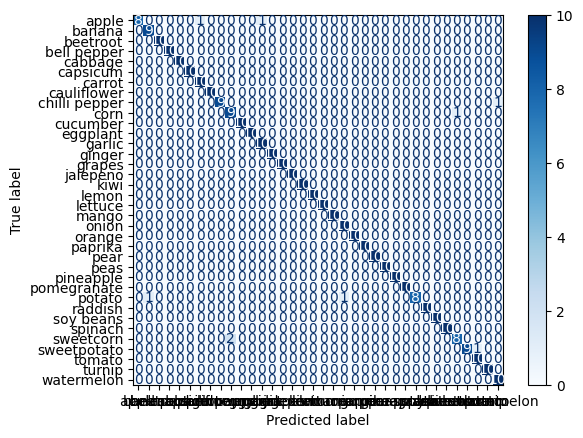

In [17]:
# Step 9: Visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_test, labels_test, display_labels=categories, cmap='Blues')
plt.show()


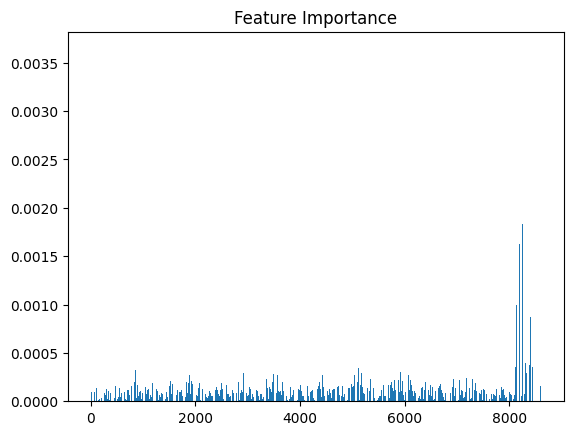

In [18]:
import matplotlib.pyplot as plt

feature_importance = classifier.feature_importances_
plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Feature Importance")
plt.show()
